# Arquitectura Propia-CPU

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision
import numpy as np

import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.nn import Conv2d, Dropout

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [3]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)


C:\Users\enriq\anaconda3\envs\mlenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [1]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, pin_memory= True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False, pin_memory= True)


NameError: name 'DataLoader' is not defined

In [2]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break
    
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)
x.device

NameError: name 'train_data' is not defined

In [5]:
class AP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,84)
        self.fc4 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

In [6]:
model = AP()
model = model.cuda()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.cuda(), y_train.cuda()
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed       

epoch:  0  batch: 1000 [ 10000/60000]  loss: 0.00059718  accuracy:  99.120%
epoch:  0  batch: 2000 [ 20000/60000]  loss: 0.00007391  accuracy:  99.110%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00016288  accuracy:  99.093%
epoch:  0  batch: 4000 [ 40000/60000]  loss: 0.00088369  accuracy:  99.090%
epoch:  0  batch: 5000 [ 50000/60000]  loss: 0.00036498  accuracy:  99.050%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00078636  accuracy:  99.045%
epoch:  1  batch: 1000 [ 10000/60000]  loss: 0.00046737  accuracy:  99.370%
epoch:  1  batch: 2000 [ 20000/60000]  loss: 0.00011251  accuracy:  99.225%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 0.11985257  accuracy:  99.107%
epoch:  1  batch: 4000 [ 40000/60000]  loss: 0.00009053  accuracy:  99.138%
epoch:  1  batch: 5000 [ 50000/60000]  loss: 0.04590960  accuracy:  99.146%
epoch:  1  batch: 6000 [ 60000/60000]  loss: 0.00801894  accuracy:  99.132%
epoch:  2  batch: 1000 [ 10000/60000]  loss: 0.00015291  accuracy:  99.330%
epoch:  2  b

In [11]:
test_losses_item = []
for i in test_losses:
    print(i)
    test_losses_item.append(i.item())
test_losses_item

tensor(0.0242, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0017, device='cuda:0')
tensor(7.7398e-05, device='cuda:0')
tensor(0.0002, device='cuda:0')


[0.02415713481605053,
 0.005027800798416138,
 0.0016967884730547667,
 7.739768625469878e-05,
 0.0002037756348727271]

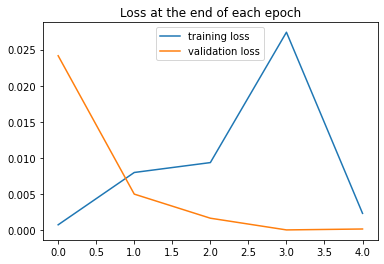

In [13]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses_item, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [14]:
test_correct_item = []
for i in test_correct:
    print(i.item())
    test_correct_item.append(i.item())
test_correct_item

9841
9867
9853
9870
9896


[9841, 9867, 9853, 9870, 9896]

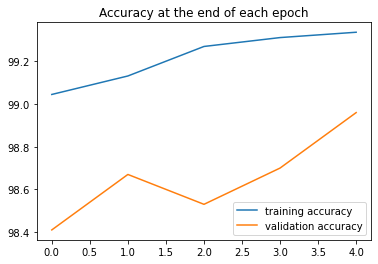

In [15]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct_item], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [16]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [17]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.cuda(), y_test.cuda()
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9896/10000 =  98.960%


In [18]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

104

In [19]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

True
Index: tensor([ 938,  965, 1014, 1039, 1112, 1114, 1202, 1226, 1232, 1260, 1290, 1299],
       device='cuda:0')
Label: tensor([3, 6, 6, 7, 4, 3, 8, 7, 9, 7, 3, 5], device='cuda:0')
Guess: tensor([5, 0, 5, 1, 6, 8, 6, 2, 4, 1, 5, 7], device='cuda:0')


C:\Users\enriq\AppData\Local\Temp/ipykernel_13252/2165462237.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Label:", y_test.index_select(0,torch.tensor(nextrow)))
C:\Users\enriq\AppData\Local\Temp/ipykernel_13252/2165462237.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Guess:", predicted.index_select(0,torch.tensor(nextrow)))
C:\Users\enriq\AppData\Local\Temp/ipykernel_13252/2165462237.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = X_test.index_select(0,torch.tensor(nextrow))


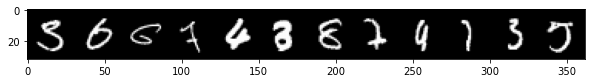

In [22]:
nextrow = next(row)
nextrow = torch.from_numpy(nextrow).to(device)
print(nextrow.is_cuda)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)))
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.cpu().numpy(), (1, 2, 0)));